Right now it is December and I suspect that Marriott stock is going to continue its bull run into January of the new year. I want a systematic way of choosing a strike price and an expiry date for a call option. I am considering two things: When Marriott goes on bull runs, how long before the bull run is over? Historically, what happens to Marriott's price around this time of year? What I mean by this is I want to look through all of the years as my dataset, and look at the similarity of what has happened this November to all of the historical samples, and use the closest ones to try and predict what will happen in the near future.

Loading historical data from cache...
Loading historical data from cache...
Loading historical data from cache...


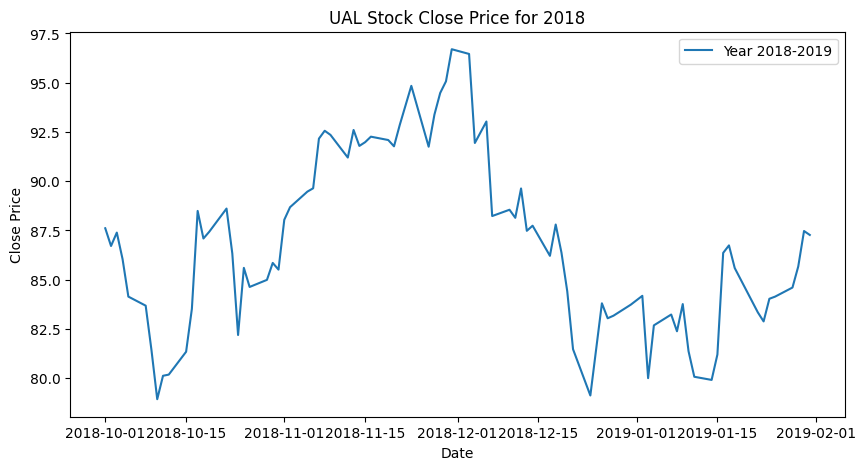

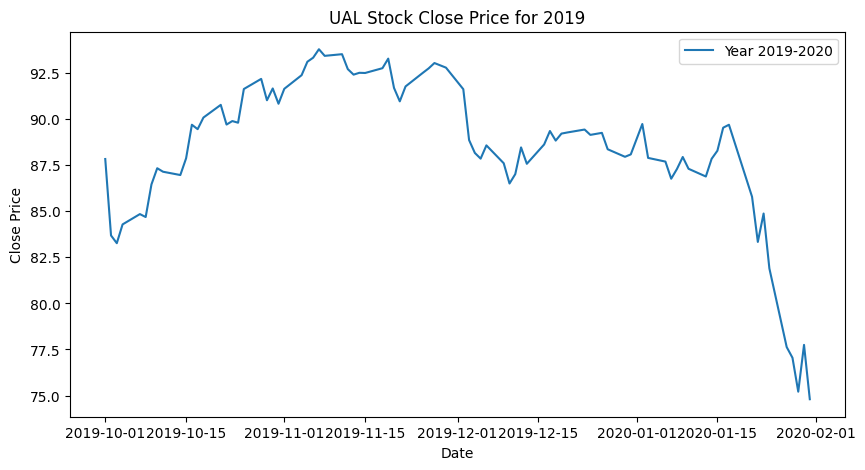

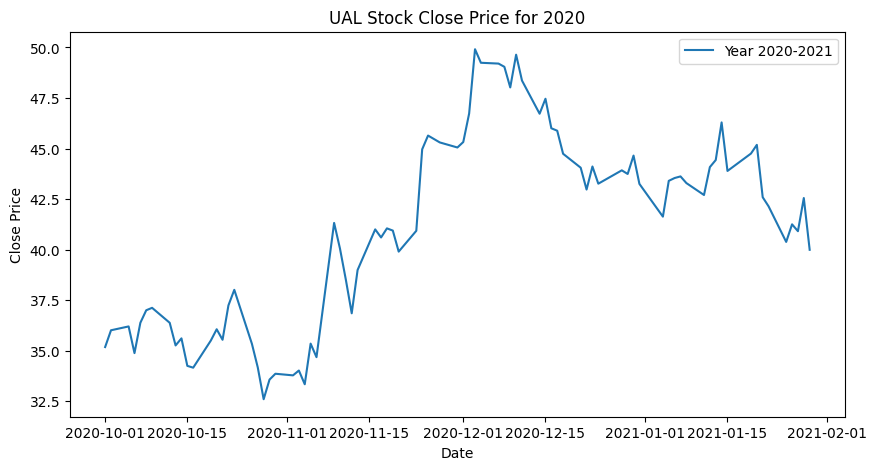

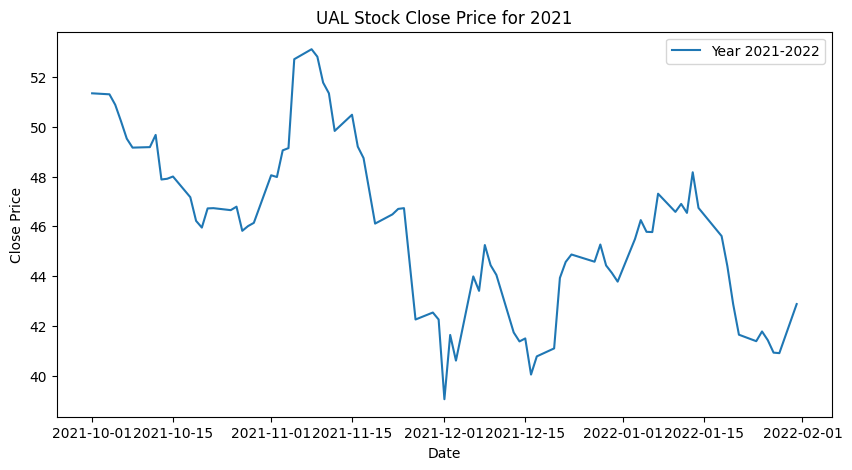

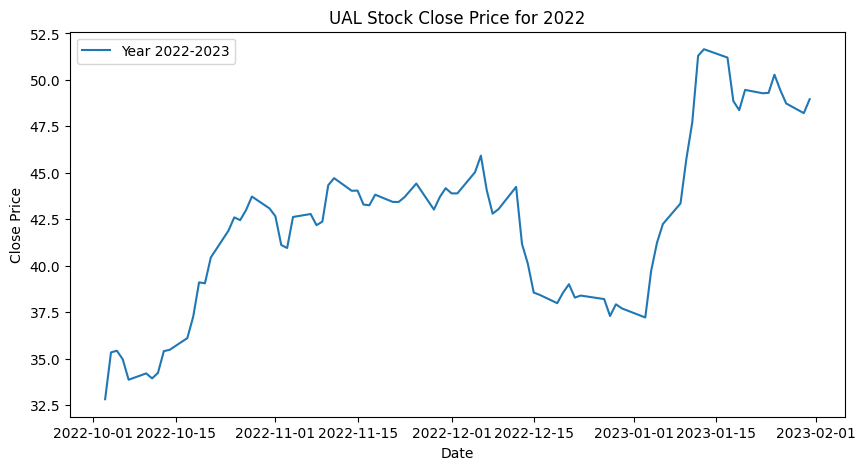

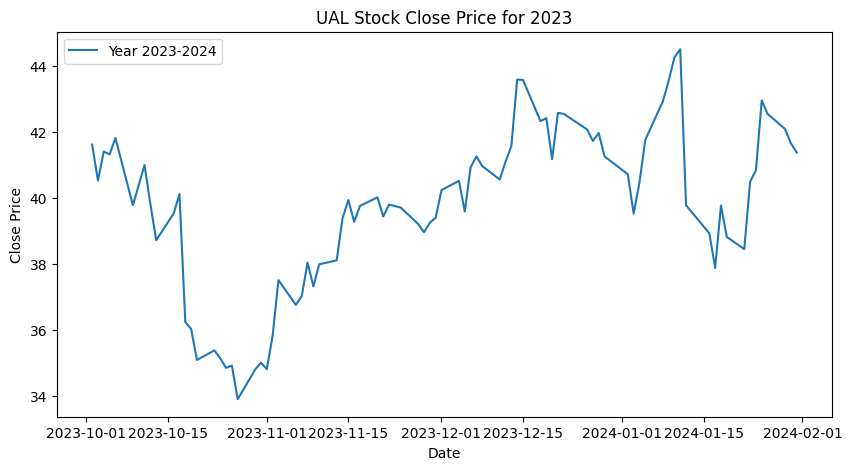

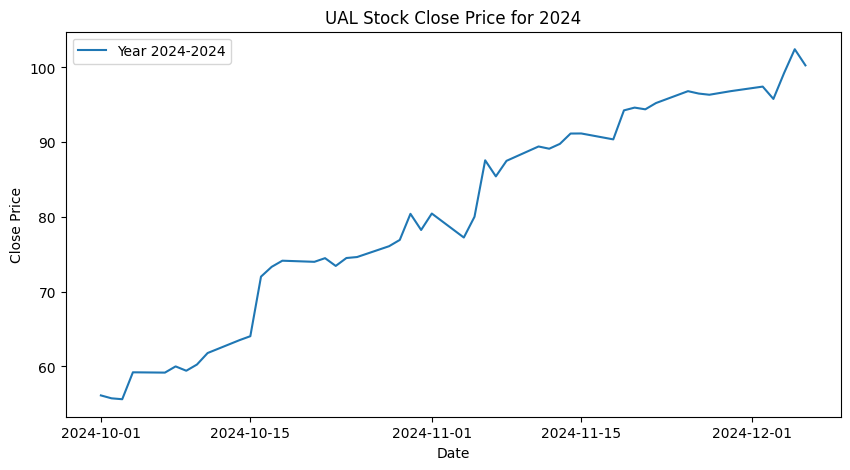

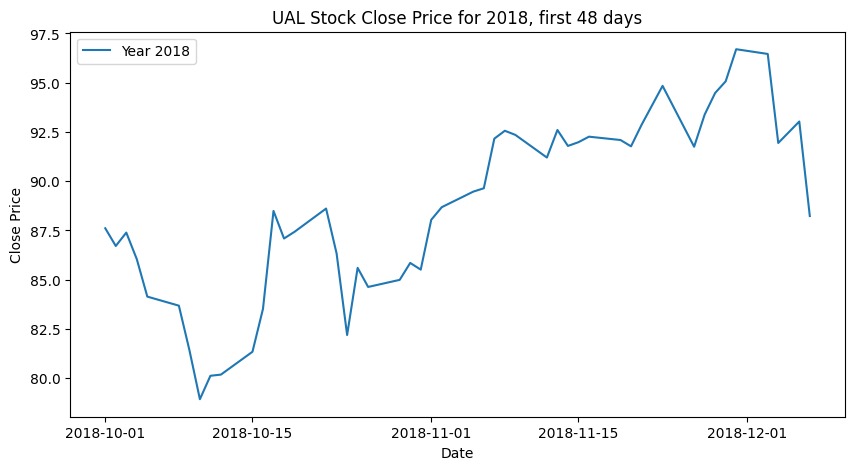

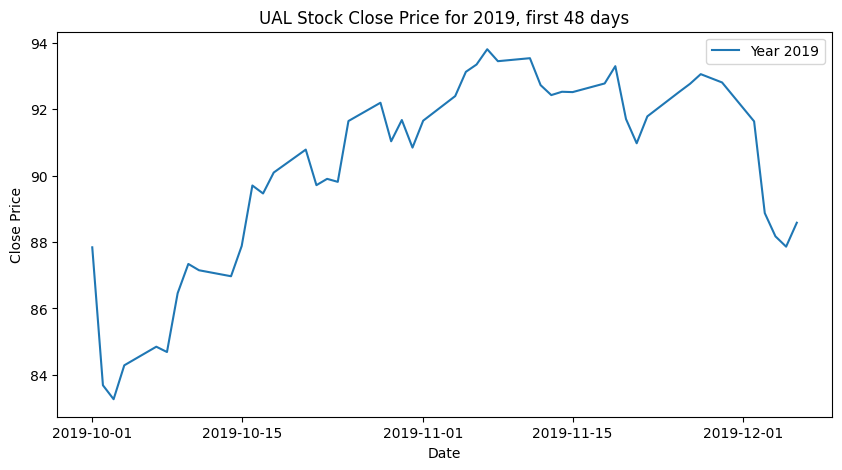

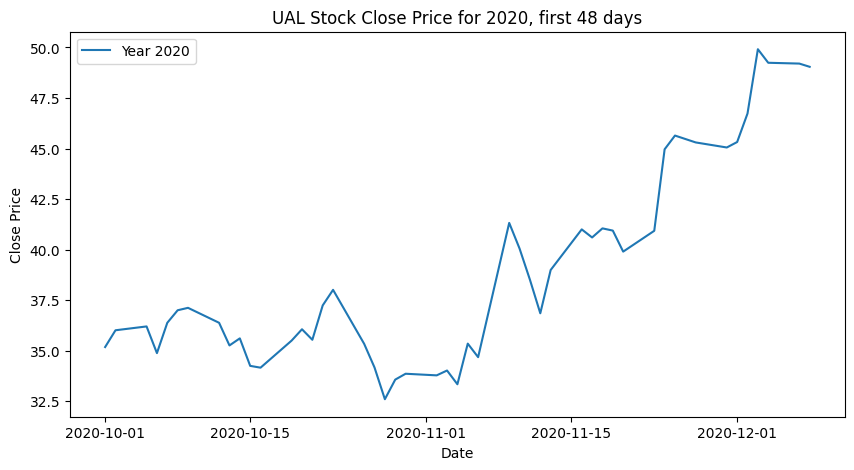

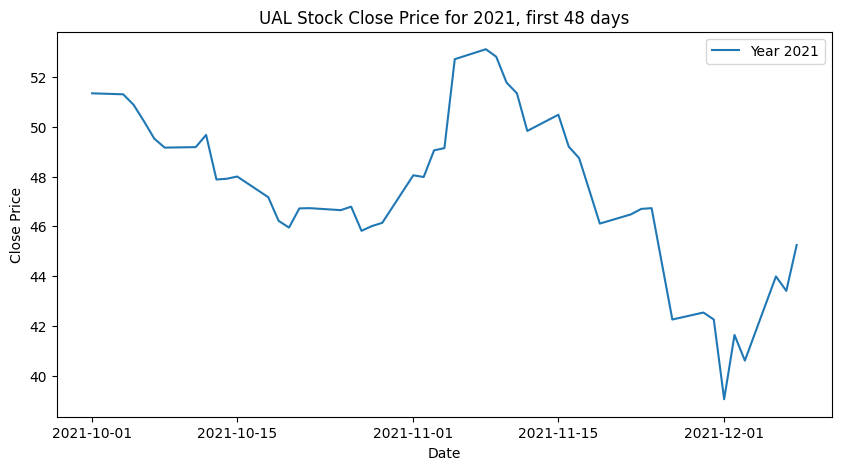

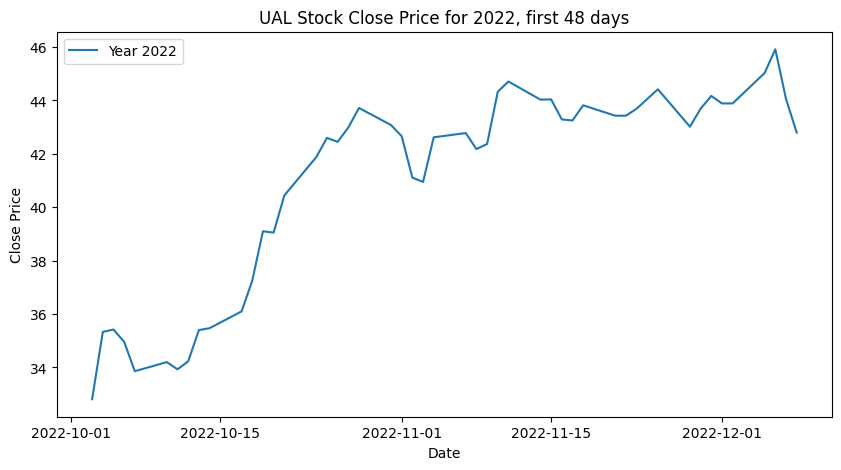

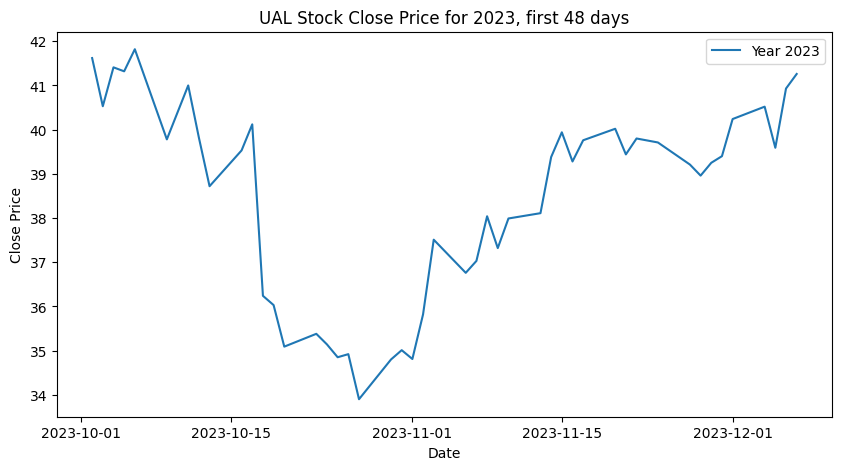

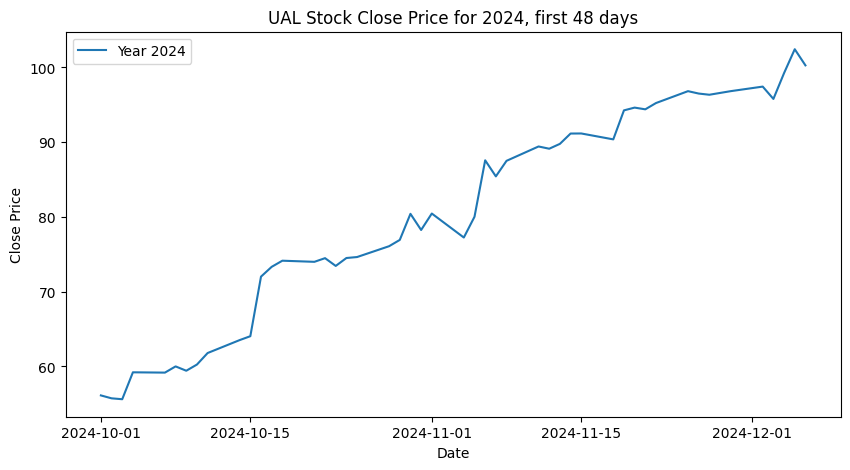

In [10]:
from backtester import Backtester
import matplotlib.pyplot as plt
stock = 'UAL'
backtester = Backtester(stock, 'SMART', 'USD')

data = backtester.max_1d_data

before = 10
# throw away all data that is not from oct to jan, all years
data = data[(data.index.month >= before) | (data.index.month <= 1)]

# sepearte data into periods of (nov, dec, jan), year by year
periods = {}
for year in data.index.year.unique():
    period = data[((data.index.year == year) & ((data.index.month >= before))) | ((data.index.year == year + 1) & (data.index.month == 1))]
    periods[year] = period
    plt.figure(figsize=(10, 5))
    plt.plot(period.index, period['close'], label=f'Year {period.index.year[0]}-{period.index.year[-1]}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(f'{stock} Stock Close Price for {year}')
    plt.legend()
    # plt.show()


n = len(periods[2024])
for year in periods:
    # plot the first n days of each period
    plt.figure(figsize=(10, 5))
    plt.plot(periods[year].index[:n], periods[year]['close'][:n], label=f'Year {year}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(f'{stock} Stock Close Price for {year}, first {n} days')
    plt.legend()
    # plt.show()







 I have isolated the months of Nov, Dec, and Jan from the past some years. Here is an idea. Consider the 2024 data, and consider the distribution of log returns for the Nov and Dec. I want to use nearest neighbors on the Nov nad Dec data from previous years to identify the closest other period, and then use the log returns of the "future" of that period as a model for what will happen in the future of 2024.

In [11]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Prepare log returns for all data
def compute_log_returns(data):
    return np.log(data['close']).diff().dropna()

# Compute log returns for all years
log_returns = {}
for year in data.index.year.unique():
    log_returns[year] = compute_log_returns(periods[year])

# Separate data into past and current
past_years = [year for year in log_returns.keys() if year != 2024]
current_year = 2024
current_year_data = log_returns[current_year]

n = len(current_year_data)

# the number of features will be n
# the neighbors will be the log returns of the past years, truncated to the first n elements
X_train = np.array([log_returns[year][:n] for year in past_years])
# show x_train
print(X_train)
nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(X_train)
distances, indices = nbrs.kneighbors(current_year_data.values.reshape(1, -1))
# Identify the closest past year
closest_year = past_years[indices[0][0]]
print(f'The closest year to {current_year} is {closest_year}')
# show all the distances
print(distances)
# show all the past years corresponding to the distances
closest_years = [past_years[i] for i in indices[0]]
print(closest_years)



#

[[-1.03259293e-02  7.81164225e-03 -1.55685552e-02 -2.23302262e-02
  -5.48207785e-03 -2.72562448e-02 -3.11823718e-02  1.49641271e-02
   7.48596417e-04  1.43637933e-02  2.64482237e-02  5.78034271e-02
  -1.59474846e-02  3.89640649e-03  1.34062449e-02 -2.60675558e-02
  -4.91435221e-02  4.06516430e-02 -1.13964695e-02  4.24478883e-03
   1.00679848e-02 -3.96825918e-03  2.91579285e-02  7.24312809e-03
   8.86898881e-03  1.89827537e-03  2.77245480e-02  4.33088594e-03
  -2.27137624e-03 -1.25308096e-02  1.52342446e-02 -8.78578242e-03
   2.06780288e-03  3.03951602e-03 -1.84431840e-03 -3.48091290e-03
   1.18075358e-02  2.10982786e-02 -3.31237743e-02  1.76097026e-02
   1.17109823e-02  6.22529048e-03  1.69999401e-02 -2.48498782e-03
  -4.79922243e-02  1.17858314e-02 -5.29749805e-02]
 [-4.83974817e-02 -5.03115580e-03  1.21748938e-02  6.62175767e-03
  -1.88746075e-03  2.06843483e-02  1.01266688e-02 -2.17777609e-03
  -2.06754036e-03  1.04090159e-02  2.04985215e-02 -2.67917106e-03
   7.01757266e-03  7.6298

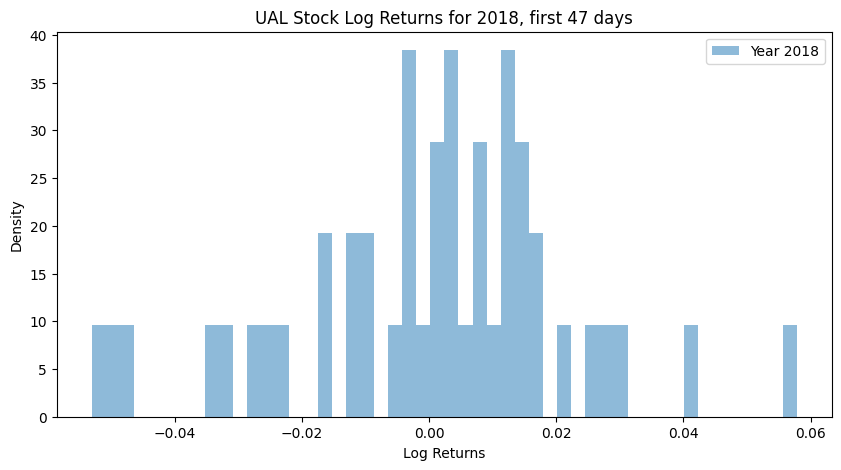

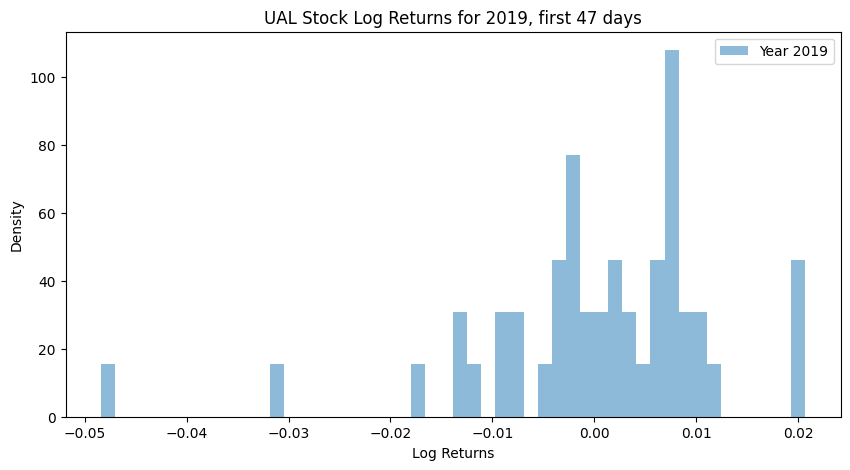

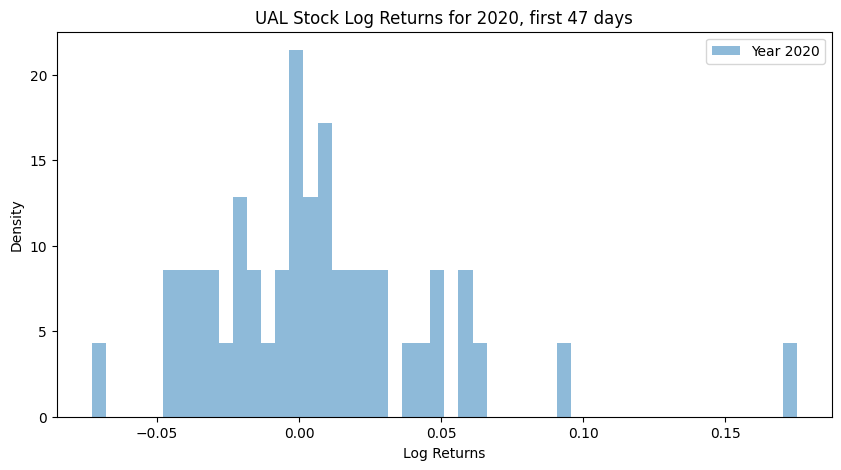

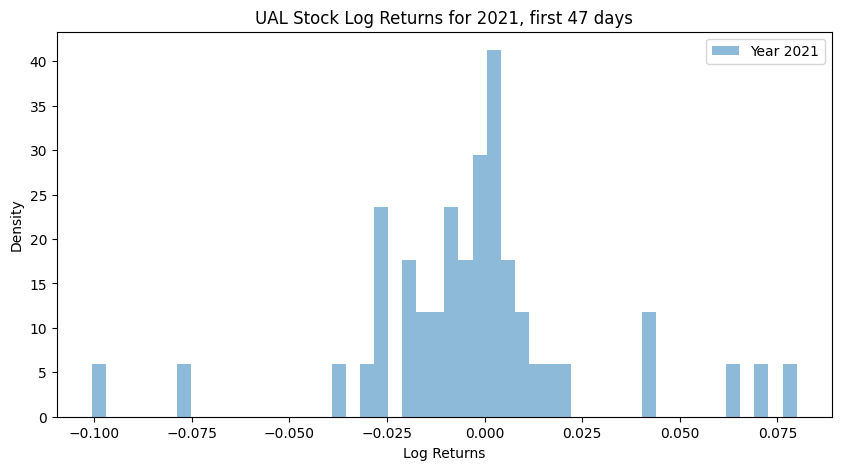

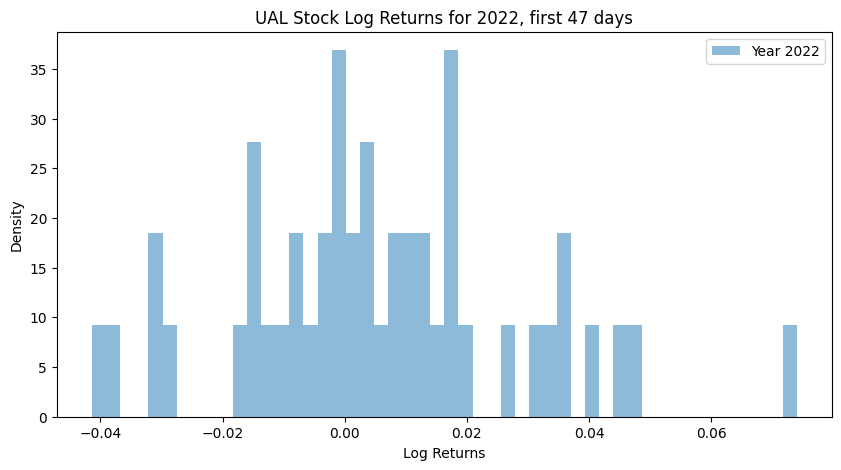

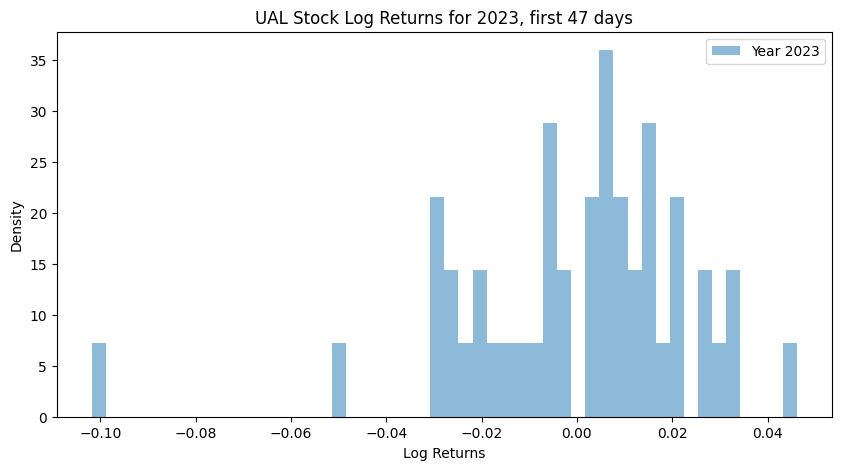

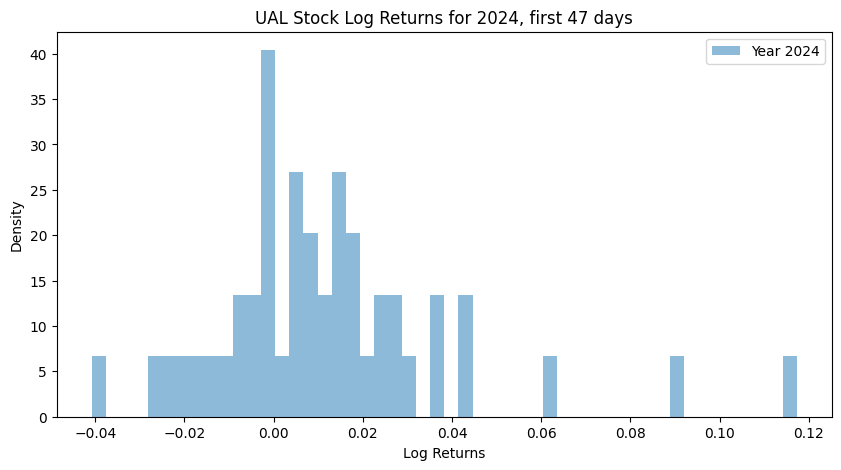

In [12]:
# plot the log returns as a histogram for each of the years, only up to the first n
for year in log_returns:
    plt.figure(figsize=(10, 5))
    plt.hist(log_returns[year][:n], bins=50, alpha=0.5, label=f'Year {year}', density=True)
    plt.xlabel('Log Returns')
    plt.ylabel('Density')
    plt.title(f'{stock} Stock Log Returns for {year}, first {n} days')
    plt.legend()
    plt.show()

In [13]:
from scipy.stats import wasserstein_distance
import numpy as np

# Compute the Wasserstein distance between distributions
def wasserstein_metric(test_data, train_data):
    distances = []
    for year_data in train_data:
        dist = wasserstein_distance(test_data, year_data)
        distances.append(dist)
    return np.array(distances)

# Create the test data and training data
test_data = current_year_data.values[:n]
train_data = [log_returns[year].values[:n] for year in past_years]

# Compute distances
distances = wasserstein_metric(test_data, train_data)

# Find the closest year
closest_idx = np.argmin(distances)
closest_year = past_years[closest_idx]

print(f'The closest year to {current_year} is {closest_year}')
print('Distances:', distances)

# Show all past years corresponding to the sorted distances
sorted_indices = np.argsort(distances)
closest_years = [past_years[i] for i in sorted_indices]
print('Closest years (sorted):', closest_years)

The closest year to 2024 is 2022
Distances: [0.01219668 0.01316944 0.01175334 0.01508628 0.0066913  0.01253156]
Closest years (sorted): [2022, 2020, 2018, 2023, 2019, 2021]


{2018: date
2018-12-07   -0.052975
2018-12-10    0.003620
2018-12-11   -0.004641
2018-12-12    0.016764
2018-12-13   -0.024280
2018-12-14    0.002968
2018-12-17   -0.017592
2018-12-18    0.018275
2018-12-19   -0.016421
2018-12-20   -0.022955
2018-12-21   -0.035451
2018-12-24   -0.029269
2018-12-26    0.057467
2018-12-27   -0.009111
2018-12-28    0.001564
2018-12-31    0.006711
2019-01-02    0.005360
2019-01-03   -0.050931
2019-01-04    0.032951
2019-01-07    0.006630
2019-01-08   -0.010265
2019-01-09    0.016613
2019-01-10   -0.028949
2019-01-11   -0.016105
2019-01-14   -0.002000
2019-01-15    0.016014
2019-01-16    0.061609
2019-01-17    0.004391
2019-01-18   -0.013347
2019-01-22   -0.026640
2019-01-23   -0.005535
2019-01-24    0.013780
2019-01-25    0.001308
2019-01-28    0.005452
2019-01-29    0.012568
2019-01-30    0.020793
2019-01-31   -0.002289
Name: close, dtype: float64, 2019: date
2019-12-09   -0.011011
2019-12-10   -0.012635
2019-12-11    0.005878
2019-12-12    0.016526
2019-

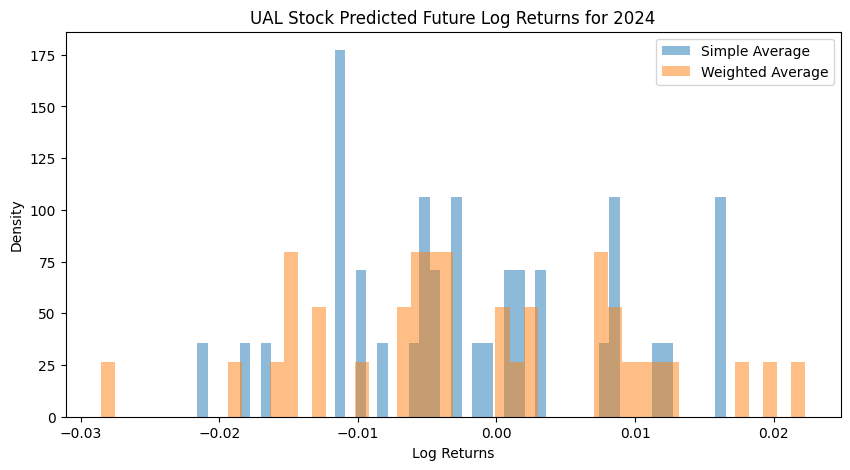

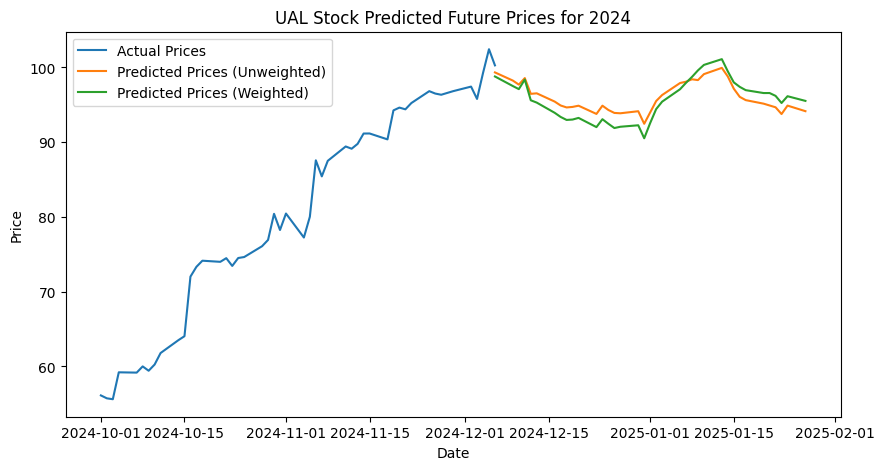

In [ ]:
future = len(periods[current_year - 1]) - n
# get last future days of each period
future_returns = {year: compute_log_returns(periods[year])[-future:] for year in past_years}
# show the future returns
print(future_returns)

# Convert dictionary values to a list
future_returns_list = list(future_returns.values())

# Simple average
predicted_future = np.mean(future_returns_list, axis=0)
print(predicted_future)

# Weighted average
weights = 1 / distances.flatten()  # Use inverse distances as weights and flatten to 1D
weights /= weights.sum()  # Normalize weights
predicted_weighted_future = np.average(future_returns_list, axis=0, weights=weights)

# Plot the predicted future returns as a histogram
plt.figure(figsize=(10, 5))
plt.hist(predicted_future, bins=50, alpha=0.5, label='Simple Average', density=True)
plt.hist(predicted_weighted_future, bins=50, alpha=0.5, label='Weighted Average', density=True)
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title(f'{stock} Stock Predicted Future Log Returns for {current_year}')
plt.legend()
plt.show()

# Use log returns to predict future prices
def predict_prices(data, log_returns):
    # Get the last price
    last_price = data['close'].iloc[-1]
    # Compute the cumulative sum of log returns
    log_returns_cumsum = log_returns.cumsum()
    # Compute the price predictions
    predicted_prices = last_price * np.exp(log_returns_cumsum)
    return predicted_prices

# Predict future prices
predicted_prices = predict_prices(periods[current_year], predicted_weighted_future)
# Convert predicted prices to a pandas Series and give it an index by adding the future days to the last day of the current year
predicted_prices = pd.Series(predicted_prices, index=pd.bdate_range(start=periods[current_year].index[-1], periods=len(predicted_prices)))

# Predict future prices for both weighted and unweighted predictions
predicted_prices_unweighted = predict_prices(periods[current_year], predicted_future)
predicted_prices_weighted = predict_prices(periods[current_year], predicted_weighted_future)

# Convert predicted prices to pandas Series and give them an index
predicted_prices_unweighted = pd.Series(predicted_prices_unweighted, index=pd.bdate_range(start=periods[current_year].index[-1], periods=len(predicted_prices_unweighted)))
predicted_prices_weighted = pd.Series(predicted_prices_weighted, index=pd.bdate_range(start=periods[current_year].index[-1], periods=len(predicted_prices_weighted)))

# Plot the predicted prices
plt.figure(figsize=(10, 5))
plt.plot(periods[current_year].index, periods[current_year]['close'], label='Actual Prices')
plt.plot(predicted_prices_unweighted.index, predicted_prices_unweighted, label='Predicted Prices (Unweighted)')
plt.plot(predicted_prices_weighted.index, predicted_prices_weighted, label='Predicted Prices (Weighted)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{stock} Stock Predicted Future Prices for {current_year}')
plt.legend()
plt.show()